<h2>Libraries</h2>

In [7]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [8]:
print(tf.__version__)
print(np.__version__)

2.8.0
1.20.3


<h2> Importing the Data </h2>

In [9]:
#importing the dataset
with open('content.json') as content:
  data1 = json.load(content)

In [10]:
#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [11]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [12]:
#printing the data
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,nice to meet you,greeting
3,"hi, is this is the pirate's organization",greeting
4,any pirates here ?,greeting
...,...,...
76,tell me more about the pre requisites,prerequisites
77,give more details about the pre-requisites,prerequisites
78,What are the requirements,prerequisites
79,what's the basic requirements,prerequisites


In [13]:
data = data.sample(frac=1)

<h2> Pre-Processing </h2>

Important pre-processing such as removing the punctuations, converting to lowercase, encoding the textual data to numerical data are done

In [14]:
#removing punctuations
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
77,give more details about the prerequisites,prerequisites
39,what are you,whoareyou
52,which place do you live in,whereareyou
5,hi,greeting
56,you are from,whereareyou
...,...,...
51,where do you live in,whereareyou
28,bye bro ill talk to you later,goodbye
80,what are the basic skills to get recruited,prerequisites
67,where is the straw hat center located,whereisthecenter


In [15]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

Tensorflow's tokenizer assigns a unique token to each distinct word. and padding is done to get all the data to the same length so as to send it to an rnn layer

In [16]:
input_shape = x_train.shape[1]
print(input_shape)

8


In [17]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  96
output length:  8


<h2>Neural Network</h2>

In [18]:
#creating the model

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

In [19]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [20]:
#training the model
train = model.fit(x_train,y_train,epochs=200)

Epoch 1/200
3/3 [==============================] - 4s 11ms/step - loss: 2.0808 - accuracy: 0.0988
Epoch 2/200
3/3 [==============================] - 0s 11ms/step - loss: 2.0768 - accuracy: 0.2222
Epoch 3/200
3/3 [==============================] - 0s 12ms/step - loss: 2.0732 - accuracy: 0.2222
Epoch 4/200
3/3 [==============================] - 0s 11ms/step - loss: 2.0696 - accuracy: 0.2099
Epoch 5/200
3/3 [==============================] - 0s 10ms/step - loss: 2.0658 - accuracy: 0.2099
Epoch 6/200
3/3 [==============================] - 0s 11ms/step - loss: 2.0620 - accuracy: 0.1975
Epoch 7/200
3/3 [==============================] - 0s 12ms/step - loss: 2.0579 - accuracy: 0.1975
Epoch 8/200
3/3 [==============================] - 0s 11ms/step - loss: 2.0533 - accuracy: 0.1975
Epoch 9/200
3/3 [==============================] - 0s 12ms/step - loss: 2.0489 - accuracy: 0.1975
Epoch 10/200
3/3 [==============================] - 0s 11ms/step - loss: 2.0436 - accuracy: 0.1975
Epoch 11/200
3/3 [=

<h2> Model Analysis </h2>

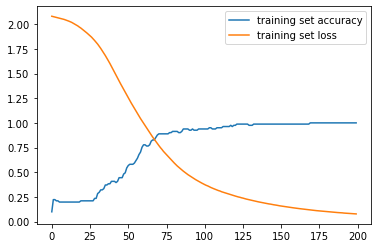

In [21]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

## Testing

In [22]:
#chatting
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Going Merry : ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

You : hi
Going Merry :  welcome aboard, how may I help you ?
You : who are you
Going Merry :  I am a The Great Pirate Bot , you can call me Going Merry
You : where is center park
Going Merry :  East Blue. That's where I live
You : okay thanks
Going Merry :  nice conversation. bye


<h2> Conclusion </h2>
So, This is the Chatbot that I have created with tensorflow2 utilizing the power of embedding matrix.<br>
This was created in memory og <b> Going Merry </b> , a ship from a manga called "One Piece" which revolves around the story of 5 pirates. 